PyTorch version: 2.6.0+cu124
CUDA: True
Device name: NVIDIA A100-PCIE-40GB
[0.8360188  0.11314284 0.05083836]
{'attention': 0, "I'm": 1, 'implementing': 2, 'mechanism': 3, 'self': 4}

Input as tensor:
tensor([1, 2, 4, 0, 3])
Embedded sentence shape: (5, 6)
[[0.59216433 0.41751945 0.96971768 0.40843603 0.48386558 0.72010424]
 [0.93824509 0.30019284 0.61418321 0.06369757 0.44467312 0.91334052]
 [0.20873908 0.38672866 0.64971255 0.15859085 0.84758727 0.94209022]
 [0.6513999  0.10252268 0.65063755 0.44795545 0.36792163 0.969667  ]
 [0.53156175 0.62276094 0.94303863 0.42179917 0.77664253 0.52856657]]

=== Original Embeddings ===
[[0.5922 0.4175 0.9697 0.4084 0.4839 0.7201]
 [0.9382 0.3002 0.6142 0.0637 0.4447 0.9133]
 [0.2087 0.3867 0.6497 0.1586 0.8476 0.9421]
 [0.6514 0.1025 0.6506 0.448  0.3679 0.9697]
 [0.5316 0.6228 0.943  0.4218 0.7766 0.5286]]

=== Positional Encoding Added the final input for the transformer encoder===
[[ 0.5922  1.4175  0.9697  1.4084  0.4839  1.7201]
 [ 1.7797  0.

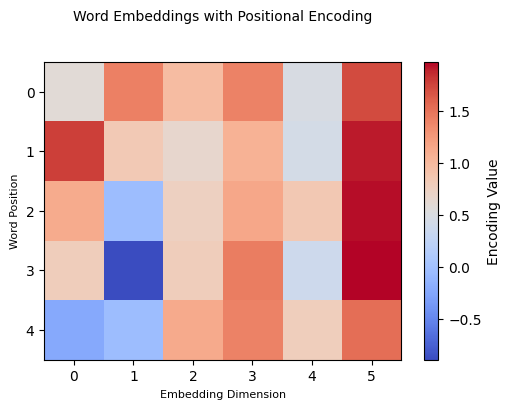

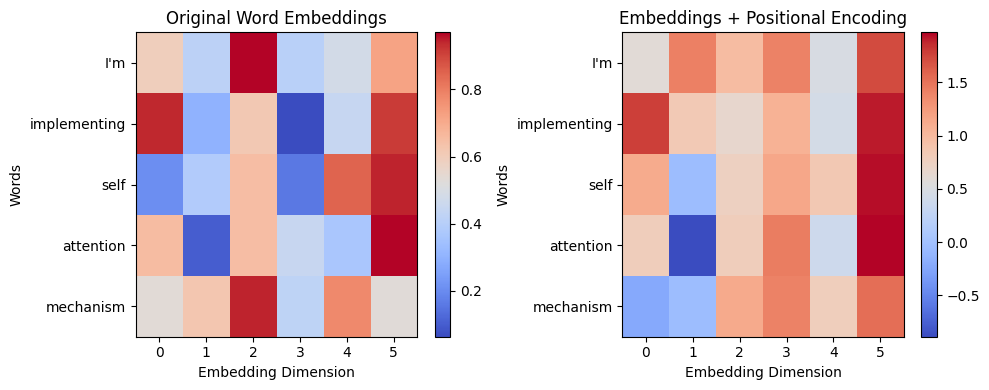

torch.Size([5, 3])
tensor([[2.1864, 1.6140, 1.8755],
        [2.1813, 1.6064, 1.8683],
        [2.1761, 1.5973, 1.8597],
        [2.1836, 1.6099, 1.8715],
        [2.1869, 1.6145, 1.8761]], grad_fn=<MmBackward0>)


In [4]:
# get everything that is present in previous notebook
%run self_attention.ipynb

In [9]:
# implementing multi-head attention
'''so In simple, why we need multi-head attention, because to get more better semantic meaning of our input.
The idea is that, we split our embedding into multiple heads, means our weight matrices of query, key, value
will be seprated into smaller pieces, and then perform attention for each and then concatenate them'''

class Multi_headAttention(nn.Module):
    def __init__(self, d_model, num_head, d_k=None, d_v=None):
        super(Multi_headAttention, self).__init__()
        assert d_model % num_head == 0 # embedding size must be divisible by no. of head
        self.num_head = num_head
        self.head_dim = d_model // num_head

        # if d_k and d_v not specified then use head_dim
        self.d_k= d_k if d_k else self.head_dim
        self.d_v= d_v if d_v else self.head_dim

        self.w_query = nn.Parameter(torch.rand(d_model, num_head*self.d_k))
        self.w_key = nn.Parameter(torch.rand(d_model, num_head*self.d_k))
        self.w_value = nn.Parameter(torch.rand(d_model, num_head*self.d_v))

        #output projection
        self.w_out = nn.Parameter(torch.rand(num_head*self.d_v, d_model))

    def forward(self, x):
        if isinstance(x, np.ndarray): # convert np array to torch tensor
            x = torch.tensor(x, dtype=torch.float32)

        sequence_length = x.shape[0]

        #linear projection
        Q = x @ self.w_query
        K = x @ self.w_key
        V = x @ self.w_value

        # splitting the projection into chunks for each head 
        Q = Q.view(sequence_length, self.num_head, self.d_k).transpose(0,1)
        K = K.view(sequence_length, self.num_head, self.d_k).transpose(0,1)
        V = V.view(sequence_length, self.num_head, self.d_v).transpose(0,1)

        # dot product
        attention_score = Q @ K.transpose(-2,-1) / math.sqrt(self.d_k)
        attention_weights = F.softmax(attention_score, dim=-1)
        context = attention_weights @ V

        # concatenate all the heads
        output = context.transpose(0,1).contiguous().view(sequence_length, -1) @ self.w_out

        return output

In [10]:
mha = Multi_headAttention(d_model=6, num_head=2)

# Pass in your embedding_sentence (same as before)
output = mha(embedding_sentence)

# Print shape and values
print("Output shape:", output.shape)
print("Output tensor:\n", output)

Output shape: torch.Size([5, 6])
Output tensor:
 tensor([[4.6396, 5.3716, 5.5621, 4.1390, 5.2697, 3.1767],
        [4.6213, 5.3553, 5.5352, 4.1168, 5.2554, 3.1695],
        [4.6200, 5.3543, 5.5322, 4.1125, 5.2549, 3.1690],
        [4.6166, 5.3501, 5.5291, 4.1122, 5.2510, 3.1673],
        [4.6516, 5.3833, 5.5788, 4.1521, 5.2799, 3.1817]],
       grad_fn=<MmBackward0>)
